In [2]:
import torch
import numpy as np
import json
import os
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
from main import set_seed
from environment import Environment
from constraints import ForwardConstraints
from trainer import Trainer

from constants import device

# Get cmd line arguments to reconstruct model
result_path = "result/diagonal_5x5_20220620_17_13_40.992363"
with open(os.path.join(result_path, "args.txt"), "r") as f:
    args_dict = json.loads(f.read())
args = argparse.Namespace(**args_dict)
print(args_dict)

{'hidden_size': 128, 'static_size': 2, 'dynamic_size': 1, 'num_layers': 1, 'dropout': 0.1, 'seed': 20, 'checkpoint': None, 'test': False, 'epoch_max': 100, 'train_size': 128, 'line_unit_price': 1.0, 'station_price': 5.0, 'result_path': None, 'actor_lr': 0.001, 'critic_lr': 0.001, 'station_num_lim': 45, 'budget': 210, 'max_grad_norm': 2.0, 'environment': 'diagonal_5x5', 'reward': 'weighted', 'ses_weight': 0, 'var_lambda': 0, 'groups_file': 'groups.txt', 'actor': 'pointer'}


In [3]:
# Load environment, constraints, and trainer
if args.seed:
    set_seed(args.seed)
environment = Environment(Path(f"./environments/{args.environment}"), groups_file=args.groups_file)
constraints = ForwardConstraints(environment.grid_x_size, environment.grid_y_size, environment.existing_lines_full, environment.grid_to_vector)
trainer = Trainer(environment, constraints, args)
trainer.load_checkpoint(result_path)
# trainer.actor.eval()

Number of trainable parameters: 182912


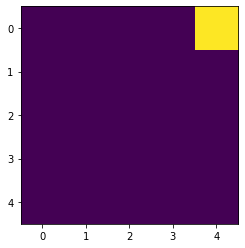

In [8]:
dynamic = torch.zeros((1, args.dynamic_size, environment.grid_size),
                            device=device).float()
data = trainer.actor.get_probs(environment.static, dynamic).view(1, 5, 5)[0].detach().numpy()
plt.imshow(data)

In [3]:
def grid_tour(environment, tour_idx):
    g = torch.zeros((environment.grid_y_size, environment.grid_x_size))
    for i, station in enumerate(tour_idx[0]):
        co = environment.vector_to_grid(station).tolist()[0]
        g[tuple(co)] = i + 1
    return g

def analyse_station_steps(trainer, environment, args):
    # Setup env and sample from model
    # Setup the initial static and dynamic states.
    static = trainer.environment.static
    dynamic = torch.zeros((1, args.dynamic_size, trainer.environment.grid_size),
                        device=device).float()  # size with batch
    # generate 128 different lines to have a bigger sample size
    station_tensor = torch.zeros(args.station_num_lim, environment.grid_x_size * environment.grid_y_size)
    for _ in range(2000):
        with torch.no_grad():
            tour_idx, _ = trainer.actor(static, dynamic, args.station_num_lim, decoder_input=None, last_hh=None)
            for i, val in enumerate(tour_idx[0]):
                station_tensor[i, val] += 1

    # Remove zero count stations
    station_tensor = [s for s in station_tensor if s.sum()]

    nrows = int(np.ceil(len(station_tensor)/5))
    ncols = min(len(station_tensor), 5)
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
    if nrows == 1:
        axs = np.expand_dims(axs, axis=0)

    for i, station in enumerate(station_tensor):
        data = np.zeros((environment.grid_x_size, environment.grid_y_size))
        for gridnr, val in enumerate(station):
            coordinate = environment.vector_to_grid(torch.Tensor([gridnr])).type(torch.long).tolist()
            data[coordinate[0]][coordinate[1]] = val
        axs[i // ncols][i % ncols].title.set_text(f"Station {i + 1} frequency")
        axs[i // ncols][i % ncols].imshow(data)

    for i in range(len(station_tensor), nrows * ncols):
        axs[i // ncols][i % ncols].imshow(np.zeros((environment.grid_x_size, environment.grid_y_size)))

    plt.tight_layout()
    plt.show()




/home/lo/git/fair-network-expansion/environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (vector_idx // self.grid_y_size)


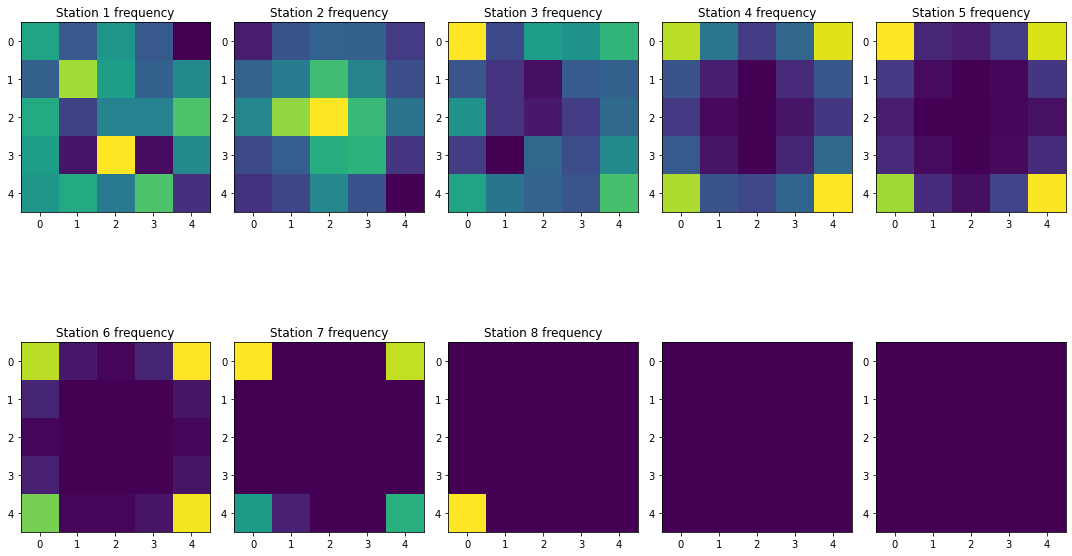

In [4]:
analyse_station_steps(trainer, environment, args)

In [305]:
mask2 = torch.arange(0, 25, device=device).view(5,5)
print(mask2)
idx = torch.Tensor([3,1,2,3,3]).type(torch.long)

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])


In [306]:
print(mask2)
test = [[i,stat] for i, stat in enumerate(idx.tolist())]
torch.index_select(mask2, dim=1, index=idx)

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])


tensor([[ 3,  1,  2,  3,  3],
        [ 8,  6,  7,  8,  8],
        [13, 11, 12, 13, 13],
        [18, 16, 17, 18, 18],
        [23, 21, 22, 23, 23]])